# Modeling Proceedure Overview 

Given our set of features surrounding credit classification we define a broad theorotical model: 

```
Credit Rating ~ Demographic Factors + Financial Hygeine + Loan Factors 
```

These features have been explored in some detail in the accompanying notebook: `Exploratory.ipynb`. When used in combination they provide a comprehensive profile of an individuals credit rating. 

After performing feature extraction and modeling fitting procedure our model is capable of detecting credit risk with an average accuracy of **76.4%**. 

## Suggested Next Steps
Given time constraints I would like to outline what some of the next steps for this excercise might look like: 

### Oversampling During Training Stage
Given the class imbalance in the data set we could perform oversampling during the training stage to improve our classifiers understanding of the minority class -- see docs for SMOTE https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html 

In additon to the observed class imbalance in the repsonse variable there is also an imblance in the number of female subjects and non-foreign workers included in this sample. This imbalance could cause issues in applying this model to a larger population. 

### Experiment with other classifiers 
Handfull of other classifiers to try: 
- SVM (one class): Handles imbalanced data without the need for resampling techniques
- Tree based approaches 

### Hyper Parameter Tuning 
This is typically the last thing to spend time on as it usually yields the least amount of model improvement compared to feature engineering/model selection/sampling techniques.

# Implementation 

The sections that follow are intended for a technical audience and detail the implementation of the Credit Rating model. 

#### Required Dependencies 

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Manipulation
import pandas as pd
import numpy as np

# ML Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression

# Model Validation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

# Data Visualization
import matplotlib.pylab as plt
plt.style.use('.config/plot_default_config.mplstyle')

#### Load Data 

In [2]:
data = pd.read_csv("./data/credit.csv")

## ML Pipeline 

Sketch of the current pipeline: 
- Cast variables into pre-defined types 
- Apply standard scaler to numeric input
- Perform one-hot encoding on categorical data 
- Fit Logistic classification model

### Column Transformers 

`ColumnTransformer` allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. 

In [3]:
def int_to_float(X: np.array):
    """Cast array of int64 to array of float64"""
    return X.astype(float)

num_features = ['duration', 'credit_amount', 'installment_commitment', 
       'residence_since', 'age', 'existing_credits', 'num_dependents']
num_transformer = Pipeline(steps=[
    ('cast_float', FunctionTransformer(int_to_float)), # Included to supress StandardScaler DataConversion warnings
    ('scaler', StandardScaler())])

cat_features = ['checking_status', 'credit_history', 'purpose',
        'savings_status', 'employment', 'personal_status', 'other_parties',
        'property_magnitude', 'other_payment_plans', 'housing', 'job',
        'own_telephone', 'foreign_worker']
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])


preprocessing = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)])

### Assemble ML Pipepline 

Here we define the steps involved with fitting our logistic regressor. This pipeline contains the necessary transformations/encoding procedures required to fit this classifer. 

In [41]:
clf = Pipeline(steps=[('preprocessing', preprocessing),
                      ('logistic_classifier', LogisticRegression(solver='lbfgs', random_state=12))])

### Fit Model 

Here we conduct the test-training split as well as encode the response variable as an integer 

In [42]:
X = data.drop('class', axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

def class_encode(X: np.array):
    """Cast 'good' -> 1 'bad' -> 0"""
    return [1 if x == "good" else 0 for x in X]
y_train, y_test = class_encode(y_train), class_encode(y_test)

clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('cast_float', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function int... penalty='l2', random_state=12, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [46]:
print("Average Accuracy: %.3f" % clf.score(X_test, y_test))

Average Accuracy: 0.764


## Model Validation 

In the section that follows we make use of two model diagnostic plots: Receiver operating characteristic (ROC) curve  and Precision Recall (PR) curve. In practice the needs of the model end user will dictate which curve is used to assess performance ( see description below ). 

- ROC Curve: Performance of classifier given an assortment of baseline probabilities of bad credit across different thresholds 
- PR Curve: Performance of classifer given the empirical baseline probability of bad credit across different thresholds

Selecting the appropriate threshold is a dependent on how the model's end user values the cost of making an error. 

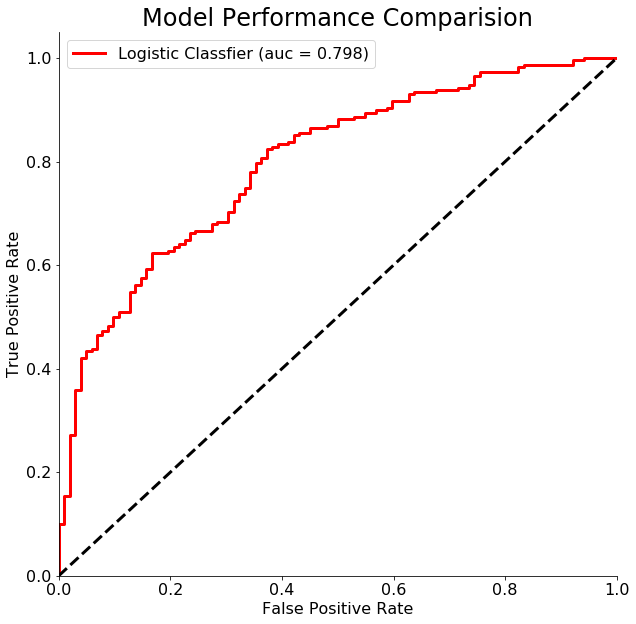

In [44]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(fpr, tpr, label='Logistic Classfier (auc = %0.3f)' % auc(fpr,tpr), color='r')

ax.plot([0, 1], [0, 1],'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.set_title('Model Performance Comparision', fontsize=24)
ax.legend( fontsize=16);

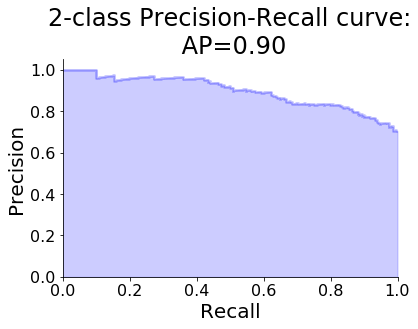

In [45]:
y_score = clf.decision_function(X_test)

average_precision = average_precision_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)


# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')


plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('2-class Precision-Recall curve:\n AP={0:0.2f}'.format(
          average_precision));